In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split # Importing train_test_split to split the dataset into training and testing sets

In [122]:
device = (
    "cuda"  # Use "cuda" (NVIDIA GPU) if a CUDA-compatible GPU is available on the system.
    if torch.cuda.is_available()  # Check if CUDA is available.
    else "mps"  # Use "mps" (Metal Performance Shaders) if running on a macOS device with MPS support.
    if torch.backends.mps.is_available()  # Check if MPS is available.
    else "cpu"  # Default to "cpu" if neither CUDA nor MPS is available, meaning the model will run on the CPU.
)

In [123]:
# load dataset
df = pd.read_csv('df_normalized.csv')

In [124]:
X_columns = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction']

X = df[X_columns] # take columns we want for training
Y = df['Churn'] # take the value we want to predict

In [125]:
xTrain,xTest,yTrain,yTest=train_test_split(X,Y,test_size=0.30,random_state=42)

In [126]:
xTrainTensor = torch.tensor(xTrain.values, dtype=torch.float32)
yTrainTensor = torch.tensor(yTrain.values, dtype=torch.float32)
xTestTensor = torch.tensor(xTest.values, dtype=torch.float32)
yTestTensor = torch.tensor(yTest.values, dtype=torch.float32)

In [127]:
train_dataset = TensorDataset(xTrainTensor, yTrainTensor)
test_dataset = TensorDataset(xTestTensor, yTestTensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [128]:
# Print the shape of the `xTrainTensor` tensor, which represents the feature input for training.
# The shape is typically `(number_of_samples, number_of_features)`.
print("X_train shape:", xTrainTensor.shape)

# Print the shape of the `yTrainTensor` tensor, which contains the target labels for training.
# The shape is typically `(number_of_samples,)`, where each element corresponds to a label.
print("y_train shape:", yTrainTensor.shape)

# Print the total number of samples in the `train_data` TensorDataset.
# This should match the number of rows in `xTrainTensor` and `yTrainTensor`.
print("train_data length:", len(train_dataset))

X_train shape: torch.Size([353644, 9])
y_train shape: torch.Size([353644])
train_data length: 353644


In [129]:
learning_rate = 0.001  # Set the learning rate for the optimizer. This value determines the step size for updating model parameters during training.
num_epochs = 20  # Specify the number of training epochs. Each epoch represents one complete pass through the entire training dataset.
batch_size = 32  # Define the batch size for the DataLoader. This is the number of samples processed together before updating the model.

In [130]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # First hidden layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),  # Second hidden layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),  # Output layer
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.model(x)

In [131]:
# Define model parameters

# Determine the number of input features for the model.
input_size = xTrainTensor.shape[1]
model = NeuralNet(input_size)




In [132]:
from torchsummary import summary  # Import the torchsummary library for model visualization.

# Create an instance of the `DeepDenseNLPModel` with the specified input size, hidden size, and number of output classes.
# Move the model to the appropriate device (CPU or GPU).
nn_model = NeuralNet(input_size=input_size).to(device)

# Print the summary of the deep model, specifying the input size for visualization.
print("\nmodel Summary:")
summary(nn_model, input_size=(input_size,))


model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,280
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
           Sigmoid-8                    [-1, 1]               0
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [133]:
# Define the loss function for the classification task.
# `CrossEntropyLoss` is a standard loss function for multi-class classification problems.
# It calculates the difference between the predicted class probabilities and the true class labels.

criterion = nn.BCELoss()

In [134]:
# Create an optimizer for the deep residual model.
# Configure the Adam optimizer for the deep model, using its parameters.

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [135]:
# Variables to store metrics
loss_per_epoch = []
accuracy_per_epoch = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        # Forward pass
        logits = model(X_batch).squeeze()
        
        # Compute loss
        loss = criterion(logits, y_batch.float())
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate predictions and accuracy
        preds = (logits > 0.5).int()  # Binary classification: Threshold at 0.5
        correct_predictions += (preds == y_batch.int()).sum().item()
        total_samples += y_batch.size(0)

    # Calculate epoch metrics
    avg_loss = train_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    # Store metrics
    loss_per_epoch.append(avg_loss)
    accuracy_per_epoch.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1/20, Loss: 0.3345, Accuracy: 0.8841
Epoch 2/20, Loss: 0.2837, Accuracy: 0.9136
Epoch 3/20, Loss: 0.2771, Accuracy: 0.9158
Epoch 4/20, Loss: 0.2740, Accuracy: 0.9172
Epoch 5/20, Loss: 0.2724, Accuracy: 0.9173
Epoch 6/20, Loss: 0.2706, Accuracy: 0.9185
Epoch 7/20, Loss: 0.2700, Accuracy: 0.9186
Epoch 8/20, Loss: 0.2692, Accuracy: 0.9189
Epoch 9/20, Loss: 0.2685, Accuracy: 0.9192
Epoch 10/20, Loss: 0.2681, Accuracy: 0.9196
Epoch 11/20, Loss: 0.2674, Accuracy: 0.9198
Epoch 12/20, Loss: 0.2669, Accuracy: 0.9195
Epoch 13/20, Loss: 0.2666, Accuracy: 0.9200
Epoch 14/20, Loss: 0.2664, Accuracy: 0.9200
Epoch 15/20, Loss: 0.2663, Accuracy: 0.9200
Epoch 16/20, Loss: 0.2652, Accuracy: 0.9201
Epoch 17/20, Loss: 0.2653, Accuracy: 0.9205
Epoch 18/20, Loss: 0.2650, Accuracy: 0.9206
Epoch 19/20, Loss: 0.2650, Accuracy: 0.9207
Epoch 20/20, Loss: 0.2643, Accuracy: 0.9210


In [136]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch).squeeze()
        y_pred_list.extend(y_pred)

# Convert predictions to binary labels
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred_list]

# Print Classification Report
print("Classification Report:")
print(classification_report(yTest, y_pred_binary))
print(f"Accuracy: {accuracy_score(yTest, y_pred_binary):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     67461
           1       0.90      0.97      0.93     84101

    accuracy                           0.92    151562
   macro avg       0.93      0.92      0.92    151562
weighted avg       0.92      0.92      0.92    151562

Accuracy: 0.92


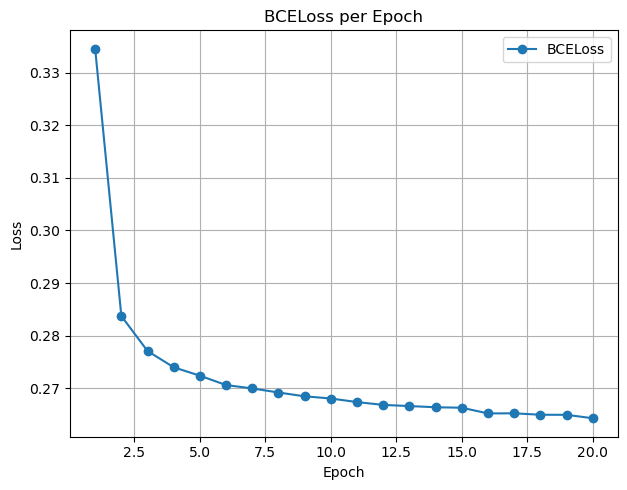

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_per_epoch, marker='o', label='BCELoss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BCELoss per Epoch')
plt.legend()
plt.grid()


#Show plot
plt.tight_layout()
plt.show()

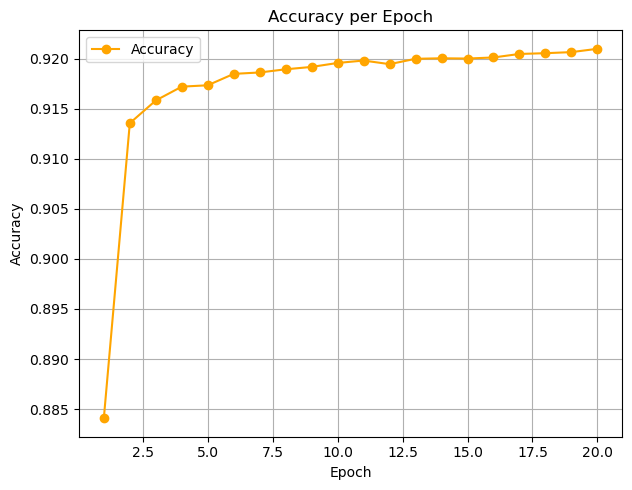

In [138]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch, marker='o', color='orange', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid()


#Show plot
plt.tight_layout()
plt.show()